Adam Ten Hoeve, Jared Pino, Joseph Plata  
COMP 4431 - Data Mining  
Assignment 9

In [1]:
# Load Required packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from pandas_profiling import ProfileReport

from IPython.display import display
    
%matplotlib inline

We have a basket of mushrooms, and are getting a bit peckish for a mushroom stew. Let's try to figure out which mushrooms would result in the best stew. By best, we mean one that is non-poisonous, smells good and is visually appealling. Let's start by examining our mushrooms, to get a better idea of what aspects we can make our decisions on.

In [2]:
# Load the data from the online archive
data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data'
info_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.names'

data = pd.read_csv(data_url, header=None)
data.columns =['class' , 'cap_shape', 'cap_surface', 'cap_color', 'bruises', 'odor', 'gill_attachment', 'gill_spacing', 
               'gill_size', 'gill_color', 'stalk_shape', 'stalk_root', 'stalk_surface_above_ring', 'stalk_surface_below_ring', 
               'stalk_color_above_ring', 'stalk_color_below_ring', 'veil_type', 'veil_color', 'ring_number',
               'ring_type', 'spore_print_color', 'population', 'habitat']
# Each mushroom should be unique, so remove any that are duplicates
data = data.drop_duplicates()

Let's take a look at our data. We may need to do some data cleaning before we can get to sorting our mushrooms. We can start by looking for any missing values.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8124 entries, 0 to 8123
Data columns (total 23 columns):
class                       8124 non-null object
cap_shape                   8124 non-null object
cap_surface                 8124 non-null object
cap_color                   8124 non-null object
bruises                     8124 non-null object
odor                        8124 non-null object
gill_attachment             8124 non-null object
gill_spacing                8124 non-null object
gill_size                   8124 non-null object
gill_color                  8124 non-null object
stalk_shape                 8124 non-null object
stalk_root                  8124 non-null object
stalk_surface_above_ring    8124 non-null object
stalk_surface_below_ring    8124 non-null object
stalk_color_above_ring      8124 non-null object
stalk_color_below_ring      8124 non-null object
veil_type                   8124 non-null object
veil_color                  8124 non-null object
ring_number

In [4]:
ProfileReport(pd.get_dummies(data))

D:\Anaconda3\lib\site-packages\pandas_profiling\describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,119
Number of observations,8124
Total Missing (%),0.0%
Total size in memory,1007.6 KiB
Average record size in memory,127.0 B
Numeric,0
Categorical,0
Boolean,110
Date,0
Text (Unique),0
Rejected,9


There are quite a few features in our dataframe, and they are all catagorical. It would take a long time to plot them all, but the Pandas Profiling tool helps us see the distributions of these variables at a glance. It also tells us:

* There are no missing or otherwise incorrect values in the data. This is helpful for us knowing that we don't have to spend time fixing up those values.
* There are quite a few categorical variables that are correlated with other variables. This makes sense, as there is likely certain mushroom attributes that go together, such as having a certain odor for a certain color of mushroom.
* Many of the attributes are imbalanced. This also makes sense, as there will be common and rarer attributes between mushroom species.
* This profiling doesn't tell us much about the interactions between the variables. In particular, how poisonous and non-poisonous mushrooms are different. Let's take a look at the most common attribute label for poisonous and edible mushrooms.

In [6]:
# Split the data into the edible and poisonous mushrooms
edible = data.loc[data["class"]=="e"]
poisonous = data.loc[data["class"]=="p"]

# Create a dataframe to store the most common label for each feature
df_common = pd.DataFrame(index=data.columns)
df_common["edible"] = edible.apply(lambda x: x.value_counts().idxmax(), axis=0)
df_common["poisonous"] = poisonous.apply(lambda x: x.value_counts().idxmax(), axis=0)
df_common

,edible,poisonous
class,e,p
cap_shape,x,x
cap_surface,f,y
cap_color,n,n
bruises,t,f
odor,n,f
gill_attachment,f,f
gill_spacing,c,c
gill_size,b,n
gill_color,w,b


We can see that some attributes, like `cap_shape` and `habitat`, are the same across both edible and poisonous mushrooms. This may be because both variables have a label that is much more common than the rest, so it makes sense to be shared across the classifications. There are a few attributes that are different between the poisonous/edible mushrooms, which is good news if we had to identify which mushrooms where poisonous.

Let's do some feature engineering for this dataset. We know that the 8124 mushrooms represented in this dataframe come from 23 different species. However, they are not labeled with species they come from. We can do some unsupervised modelling to group similar mushrooms into groups that we can label as being different species. For this classification task, we will use a KNN algorithm.

In [7]:
from sklearn.cluster import KMeans

mushrooms = data.copy()
num_species = 23
kmeans = KMeans(n_clusters=num_species, random_state=0).fit(pd.get_dummies(mushrooms))
mushrooms["species"] = kmeans.labels_

In [ ]:
# this cell finds permutations/combinations of columns that create 23 unique rows, then runs KNN to find which of those
# combinations provides best clustering
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from itertools import combinations

#label encoder
labelencoder = LabelEncoder()
data_labelled = mushrooms.apply(LabelEncoder().fit_transform)

X = data_labelled.copy()
arr = data_labelled.columns.tolist()

j = 0
s = 'group_'
final_score = 0
final_group = 0
final_sample = 0

def rSubset(arr, r):
      return list(combinations(arr, r))

def KNN_function(target):
    y = target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    model = KNeighborsClassifier(n_neighbors=15)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = metrics.accuracy_score(y_test, y_pred)
    return score

for r in range(2,8):
    sub = rSubset(arr, r)
    for i in range(len(sub)):
        sample = sub[i]
        current = data_labelled[list(sample)].drop_duplicates()
        current_shape = current.shape[0]
         #all combinations need to include 'class' 
        if current_shape == 23 and list(sample)[0] == 'class':
            group = s + str(j)
            data_labelled[group] = data_labelled.groupby(list(sample)).ngroup()
            current_score = KNN_function(data_labelled[group])
#            print("Accuracy:", group, current_score)
            if current_score > final_score:
                final_score = current_score
                final_group = group
                final_sample = sample
            j += 1
    print(final_sample, final_group, final_score)
    
mushrooms['species'] = data_labelled[final_group]

Now, we don't have a target variable just yet. We know that we want a soup that meets certain requirements, like being visually appealing, but that's not give to us in the dataset. That means we're going to have to fill in these values ourselves. To do this, we went through every level of each category and thought about how well it would score for our stew. We gave each level a point value, and a mushroom's overall value is the multiplicative combination of those individual scores. We just need to map each level to its corresponding value.

In [8]:
df = mushrooms.copy()
df = df.drop(columns=["gill_attachment","gill_spacing","gill_size","stalk_root","stalk_color_above_ring",
                       "stalk_color_below_ring","veil_type","veil_color","ring_number","ring_type","population"])

In [9]:
cap_shape = {"b":3,"c":1,"x":5,"f":3,"k":2,"s":4}
cap_surface = {"f":2,"g":2,"y":2,"s":5}
cap_color = {"n":5,"b":2,"c":2,"g":2,"r":1,"p":0,"u":1,"e":3,"w":5,"y":4}
bruises = {"t":1,"f":5}
odor = {"a":4,"l":3,"c":1,"y":2,"f":1,"m":1,"n":3,"p":2,"s":2}
gill_color = {"k":3,"n":4,"b":3,"h":4,"g":1,"r":1,"o":1,"p":2,"u":1,"e":1,"w":4,"y":4}
stalk_shape = {"e":4,"t":2}
stalk_surface_above_ring = {"f":4,"y":1,"k":2,"s":5}
stalk_surface_below_ring = {"f":4,"y":1,"k":2,"s":5}
spore_print_color = {"k":3,"n":4,"b":3,"h":4,"r":0,"o":1,"u":2,"w":4,"y":4}
habitat = {"g":1,"l":1,"m":1,"p":1,"u":1,"w":0,"d":1}

attributes = ['cap_shape', 'cap_surface', 'cap_color', 'bruises' , 'odor', 'gill_color', 'stalk_shape', 'stalk_surface_above_ring', 
             'stalk_surface_below_ring', 'spore_print_color' , 'habitat']

for i in attributes:
    y = globals()[i]
    df[i] = df[i].apply(lambda x: y[x])
    
df.head()

,class,cap_shape,cap_surface,cap_color,bruises,odor,gill_color,stalk_shape,stalk_surface_above_ring,stalk_surface_below_ring,spore_print_color,habitat,species
0,p,5,5,5,1,2,3,4,5,5,3,1,9
1,e,5,5,4,1,4,3,4,5,5,4,1,10
2,e,3,5,5,1,3,4,4,5,5,4,1,10
3,p,5,2,5,1,2,4,4,5,5,3,1,9
4,e,5,5,2,5,3,3,2,5,5,4,1,15


There are multiple different scores that we could give our mushrooms. Maybe some taste better, while others look better. To figure this out, we spent all night arguing about what combinations of features affect the taste, appearance and texture of each mushroom. Finally, we decided on the combinations below for our final scores.

In [10]:
#flavor based on odor and habitat
df['taste'] = df['odor'] * df['habitat']

#appearance based on a combination of color and bruising
df['appearance'] = df['cap_color'] * df['gill_color'] * df['spore_print_color'] * df['bruises']

#texture based on a combination shapes and sizes
df['texture'] = df['cap_shape'] * df['cap_surface'] * df['stalk_shape'] * df['stalk_surface_above_ring'] * df['stalk_surface_below_ring']


We've given each attribute a score for our mushrooms, now we want to combine those scores into a single "overall mushroom greatness" score. Again, after much debate, we've concluded that taste is more important then appearance, which is more important than texture. To codify this, our final score follows the following equation:

$$ \text{Total} = 3 \times \text{Taste} + 2\times\text{Appearance} +\text{Texture} $$

In [11]:
#min_max scaling 
df_final = df[['taste', 'appearance', 'texture']].copy()

x = df_final.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
#df = pd.DataFrame(x_scaled)

df = df.drop(columns=['taste', 'appearance', 'texture'])
column_values = ['taste', 'appearance', 'texture']
df = df.join(pd.DataFrame(x_scaled, columns = column_values))


#weightings (weighted taste > appearance > texture)
df['taste'] = df['taste'] * 3
df['appearance'] = df['appearance'] * 2

#final score
df['total_score'] = df['taste']+df['appearance']+df['texture']

df.head()

,class,cap_shape,cap_surface,cap_color,bruises,odor,gill_color,stalk_shape,stalk_surface_above_ring,stalk_surface_below_ring,spore_print_color,habitat,species,taste,appearance,texture,total_score
0,p,5,5,5,1,2,3,4,5,5,3,1,9,1.50,0.225,1.000000,2.725000
1,e,5,5,4,1,4,3,4,5,5,4,1,10,3.00,0.240,1.000000,4.240000
2,e,3,5,5,1,3,4,4,5,5,4,1,10,2.25,0.400,0.598716,3.248716
3,p,5,2,5,1,2,4,4,5,5,3,1,9,1.50,0.300,0.398074,2.198074
4,e,5,5,2,5,3,3,2,5,5,4,1,15,2.25,0.600,0.498395,3.348395


We've coded the "goodness" of each attribute ourselves, and (as we are human) that means these are subjective. It also makes sense that our subjective scores favor mushrooms that normally fall within the non-poisonous catagory. Let's check to see if that assumption is confirmed by our data.

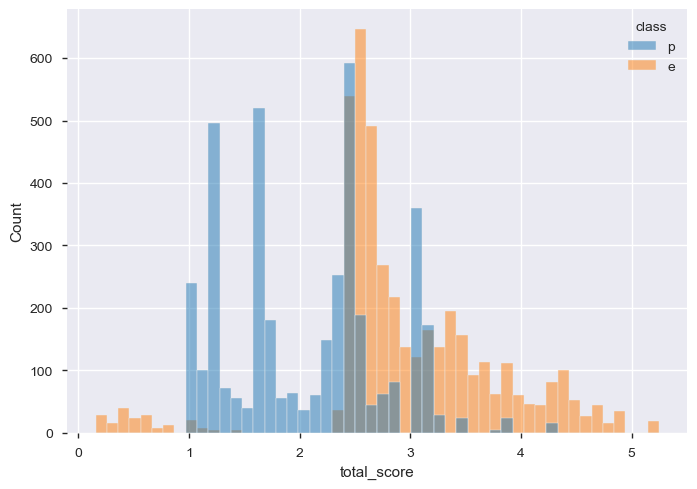

In [12]:
sns.histplot(data=df, x="total_score", hue="class")

This should display how our assigned scores are subjective, and higher scores are skewed towards edible mushrooms.

Technically, our final score is just a linear combination of our predictors. But it is a complicated linear combination, where some features where used more than others, so let's take a look at how the different feature scores relate to the final score.

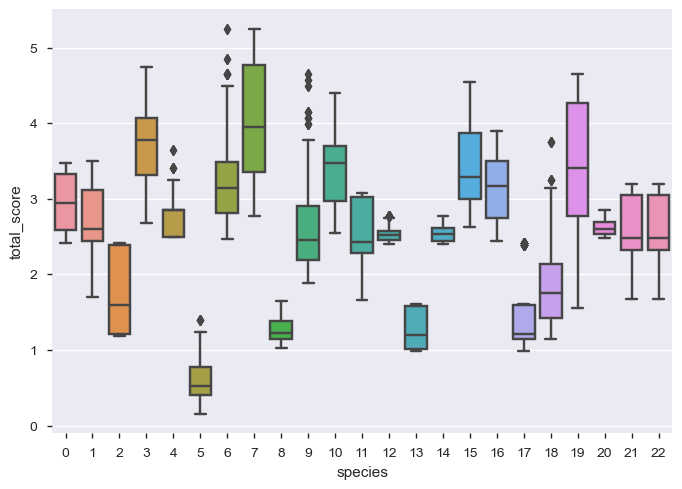

In [13]:
# Are certain species more likely to be better for our stew?
sns.boxplot(data=df, x='species', y='total_score')

From this first boxplot, we can see that there is certainly a difference between species. Species 6 and 7 both appear to score relatively highly across the board, whereas those in species 5, 8, 13, and 17 all score much lower. But this should make sense, as we haven't filtered our data at all yet. One of our requirements was that the stew is non-poisonous, so let's see how our species boxplots look if we remove all the inedible mushrooms.

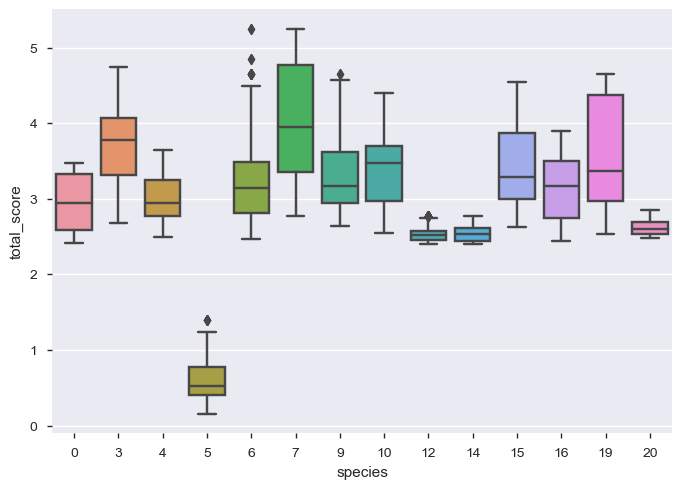

In [14]:
# filter for only edible and boxplot again
edible_mush = df.loc[mushrooms["class"] == "e"]

sns.boxplot(data=edible_mush, x='species', y='total_score')

By removing the poisonous mushrooms, we actually removed quite a few species from our considerations. Every species, besides 5, has an average rating of above 2, which is decent when looking at the boxplot of all the species.

Now we have to determine which mushrooms go into our stew! How many mushrooms do we need? Based on [this](https://www.allrecipes.com/recipe/282616/french-style-mushroom-stew/) recipe, there are 40 ounces of mushroom in a stew. And as the average mushroom is about half an ounce, we will need about 80 mushrooms for our stew. That's a lot a mushrooms! 

But that leaves us with a few options. Do we want one mushroom of the best 80 types of mushrooms, or do we want a few mushrooms of certain specific mushrooms? Maybe we can abstract this a bit. We know that certain species are present, and mushrooms within species are likely very similar. What if we determine the best species of mushroom, and then leave it up to the customer how much of each that they want?

In [15]:
# Look at the best 80 mushrooms
final_chosen = edible_mush.nlargest(80, ['total_score'])
final_chosen["species"].value_counts()

7    56
3    18
6     4
9     2
Name: species, dtype: int64

We get that species 7 was, by a lot, the most represented species, and is likely a good choice for our stew. The other species of 3, 6, and 9 also showed up in this group, meaning they are also likely a good choice for our stew.

But, leading off the idea earlier, what if the customer has different preferences than we do? We could create an application that picks different mushrooms (and classifies different species of mushrooms) based on the customer's preferences. And that's exactly what we did. The below cell allows you to input values for a stew, and determine which species of mushrooms can be used to be make that specific type of stew.

In [16]:
def get_preferences():
    # Ask the customer what they want kind of stew they want
    print("Are you okay with poisonous mushrooms? Enter 'y' or 'n'.")
    poison_okay = input()
    poison_okay = (poison_okay == "y")

    print("On a scale of 0 to 5, how important is the stew's appearance?")
    appearance = float(input())

    print("On a scale of 0 to 5, how important is the stew's taste?")
    taste = float(input())

    print("On a scale of 0 to 5, how important is the stew's texture?")
    texture = float(input())
    return poison_okay, appearance, taste, texture


def calculate_customer_scores(prefs, df_cust):
    # Using the customer's preferences, calculate the score for each mushroom.
    
    # If they don't want poisonous mushrooms, then remove them from the dataset
    if prefs[0] == 0:
        df_cust = df_cust.loc[df_cust["class"]=="e"].copy()
        
    # Calculate the score for each mushroom given the customer's preferences
    df_cust["cust_score"] = prefs[1]*df_cust["appearance"] + prefs[2]*df_cust["taste"] + prefs[3]*df_cust["texture"]
    return df_cust

                              
def find_best_species(df_cust):
    # Determine the most often occuring species of mushroom for the customer's requests
    cust_mushrooms = df_cust.nlargest(80, ["cust_score"])
    # Find the counts of each species
    return cust_mushrooms["species"].value_counts()


def order_stew():
    # Get the customer's preferences
    prefs = get_preferences()
    # Score each mushroom based on the customer's preferences
    df_cust = calculate_customer_scores(prefs, df.copy())
    # Find the best mushrooms given the customer's scores
    mushrooms = find_best_species(df_cust)
    print("The mushroom species to put in your stew are:")
    print(mushrooms)

In [18]:
order_stew()

Are you okay with poisonous mushrooms? Enter 'y' or 'n'.
y
On a scale of 0 to 5, how important is the stew's appearance?
0
On a scale of 0 to 5, how important is the stew's taste?
5
On a scale of 0 to 5, how important is the stew's texture?
0
The mushroom species to put in your stew are:
10    58
0     13
16     9
Name: species, dtype: int64


Now, we had an idea to make a Sankey diagram for this dataset. That way we could visualize how different mushrooms, or possibly mushroom attributes, eventually resulted in different stews. However, we couldn't get the diagram to work. We just kept getting errors, and eventually gave up on trying. The below code is the remains of our efforts.

In [ ]:
#function from:
# https://medium.com/kenlok/how-to-create-sankey-diagrams-from-dataframes-in-python-e221c1b4d6b0


def genSankey(df,cat_cols=[],value_cols='',title='Sankey Diagram'):
    # maximum of 6 value cols -> 6 colors
    colorPalette = ['#4B8BBE','#306998','#FFE873','#FFD43B','#646464']
    labelList = []
    colorNumList = []
    for catCol in cat_cols:
        labelListTemp =  list(set(df[catCol].values))
        colorNumList.append(len(labelListTemp))
        labelList = labelList + labelListTemp
        
    # remove duplicates from labelList
    labelList = list(dict.fromkeys(labelList))
    
    # define colors based on number of levels
    colorList = []
    for idx, colorNum in enumerate(colorNumList):
        colorList = colorList + [colorPalette[idx]]*colorNum
        
    # transform df into a source-target pair
    for i in range(len(cat_cols)-1):
        if i==0:
            sourceTargetDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            sourceTargetDf.columns = ['source','target','count']
        else:
            tempDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            tempDf.columns = ['source','target','count']
            sourceTargetDf = pd.concat([sourceTargetDf,tempDf])
        sourceTargetDf = sourceTargetDf.groupby(['source','target']).agg({'count':'sum'}).reset_index()
        
    # add index for source-target pair
    sourceTargetDf['sourceID'] = sourceTargetDf['source'].apply(lambda x: labelList.index(x))
    sourceTargetDf['targetID'] = sourceTargetDf['target'].apply(lambda x: labelList.index(x))
    
    # creating the sankey diagram
    data = dict(
        type='sankey',
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict(
            color = "black",
            width = 0.5
          ),
          label = labelList,
          color = colorList
        ),
        link = dict(
          source = sourceTargetDf['sourceID'],
          target = sourceTargetDf['targetID'],
          value = sourceTargetDf['count']
        )
      )
    
    layout =  dict(
        title = title,
        font = dict(
          size = 10
        )
    )
       
    fig = dict(data=[data], layout=layout)
    return fig

In [663]:
stuff = mushrooms.groupby(['class', 'bruises', 'odor', 'gill_size', 'stalk_shape', 'veil_type', 'ring_type', 'species']).agg('count')
stuff

cap_shape  \
class bruises odor gill_size stalk_shape veil_type ring_type species              
e     f       n    b         e           p         p         0              496   
                             t           p         e         1              768   
                   n         e           p         e         2               48   
                                                   f         3               48   
                                                   p         4               96   
      t       a    b         e           p         p         5              352   
                   n         t           p         p         6               48   
              l    b         e           p         p         7              352   
                   n         t           p         p         8               48   
              n    b         e           p         e         9              192   
                                                   p         10              32   
                             t           p         p         11            1728   
p     f       c    n         e           p         p         12             192   
              f    b         e           p         l         13            1296   
                   n         t           p         e         14             576   
              m    b         e           p         n         15              36   
              n    n         e           p         e         16              40   
              s    n         t           p         e         17             576   
              y    n         t           p         e         18             576   
      t       f    b         t           p         p         19             288   
              n    b         e           p         p         20              72   
                   n         e           p         p         21               8   
              p    n         e           p         p         22             256   

                                                                      cap_surface  \
class bruises odor gill_size stalk_shape veil_type ring_type species                
e     f       n    b         e           p         p         0                496   
                             t           p         e         1                768   
                   n         e           p         e         2                 48   
                                                   f         3                 48   
                                                   p         4                 96   
      t       a    b         e           p         p         5                352   
                   n         t           p         p         6                 48   
              l    b         e           p         p         7                352   
                   n         t           p         p         8                 48   
              n    b         e           p         e         9                192   
                                                   p         10                32   
                             t           p         p         11              1728   
p     f       c    n         e           p         p         12               192   
              f    b         e           p         l         13              1296   
                   n         t           p         e         14               576   
              m    b         e           p         n         15                36   
              n    n         e           p         e         16                40   
              s    n         t           p         e         17               576   
              y    n         t           p         e         18               576   
      t       f    b         t           p         p         19               288   
              n    b         e           p         p         20                72   
                   n         e         

In [668]:
import pandas as pd
import plotly
import chart_studio.plotly as py

fig = genSankey(mushrooms,cat_cols=['class', 'bruises', 'odor', 'gill_size', 'ring_type', 'species'],value_cols='cap_shape',title='Mushroom Attributes')
plotly.offline.plot(fig, validate=False)

IndexError: list index out of range